Data Preparation

In [1]:
import zipfile
import os

# Specify the path to your zip file
zip_path = '/content/Data.zip'

# Specify the directory to extract to
extract_to = '/content/'

# Create a directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping completed.")

Unzipping completed.


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [17]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_vae(latent_dim=2):
    # Encoder
    encoder_inputs = layers.Input(shape=(256, 256, 3))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64 * 64 * 32, activation='relu')(latent_inputs)
    x = layers.Reshape((64, 64, 32))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')

    # VAE
    vae_outputs = decoder(encoder(encoder_inputs)[2])
    vae = models.Model(encoder_inputs, vae_outputs, name='vae')

    # Loss
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(encoder_inputs, vae_outputs), axis=(1, 2)))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
    total_loss = reconstruction_loss + kl_loss
    vae.add_loss(total_loss)
    vae.compile(optimizer='adam')
    return encoder, decoder, vae


In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def load_images(image_dir, size=(256, 256)):
    images = []
    labels = []  # This could be used for supervised tasks, if needed
    filenames = os.listdir(image_dir)
    for filename in filenames:
        image_path = os.path.join(image_dir, filename)
        image = load_img(image_path, target_size=size)
        image = img_to_array(image)
        images.append(image)
    return np.array(images)

# Example directories
drone_dir = '/content/Data/Drones'
bird_dir = '/content/Data/Birds'

drone_images = load_images(drone_dir)
bird_images = load_images(bird_dir)

# Normalize the images
drone_images = drone_images.astype('float32') / 255.0
bird_images = bird_images.astype('float32') / 255.0

# Assuming you're only training on drone images
x_train = drone_images


In [19]:
latent_dim = 2
encoder, decoder, vae = build_vae(latent_dim)
vae.fit(x_train, x_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
13/13 [==============================] - 66s 5s/step - loss: 45508.1602 - val_loss: 44872.3047
Epoch 2/50
13/13 [==============================] - 59s 5s/step - loss: 44251.9961 - val_loss: 45086.3125
Epoch 3/50
13/13 [==============================] - 60s 5s/step - loss: 45107.5195 - val_loss: 44891.5859
Epoch 4/50
13/13 [==============================] - 67s 5s/step - loss: 44562.1289 - val_loss: 43515.8594
Epoch 5/50
13/13 [==============================] - 57s 4s/step - loss: 43574.9375 - val_loss: 42884.7305
Epoch 6/50
13/13 [==============================] - 77s 6s/step - loss: 43694.7969 - val_loss: 43972.4102
Epoch 7/50
13/13 [==============================] - 61s 5s/step - loss: 43933.0430 - val_loss: 44125.1484
Epoch 8/50
13/13 [==============================] - 58s 4s/step - loss: 43387.8125 - val_loss: 42430.8906
Epoch 9/50
13/13 [==============================] - 60s 5s/step - loss: 42931.7109 - val_loss: 42031.0625
Epoch 10/50
13/13 [===========================

In [21]:
# Save the model
vae.save('vae_drone_model.h5')

# Evaluate on a new image (could be either from drone or bird images for testing)
def evaluate_image(image_path, model):
    image = load_img(image_path, target_size=(256, 256))
    image = img_to_array(image)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)  # Make it batch-like
    reconstructed_image = model.predict(image)
    reconstruction_error = np.mean((image - reconstructed_image) ** 2)
    return reconstruction_error

# Path to a new image
test_image_path = '/content/Data/Birds/singleBirdinsky0.jpeg'
error = evaluate_image(test_image_path, vae)
print(f'Reconstruction error: {error}')


1/1 [==============================] - 0s 344ms/step
Reconstruction error: 0.02367558144032955


In [22]:
# Define a threshold based on your observations
threshold = 0.01  # This value should be defined based on your specific use case

# Check if an image is OOD
is_ood = error > threshold
print(f'Is out of distribution: {is_ood}')


Is out of distribution: True


In [23]:
def calculate_reconstruction_errors(images, model):
    reconstructed_images = model.predict(images)
    errors = np.mean(np.square(images - reconstructed_images), axis=(1, 2, 3))
    return errors


13/13 [==============================] - 27s 2s/step


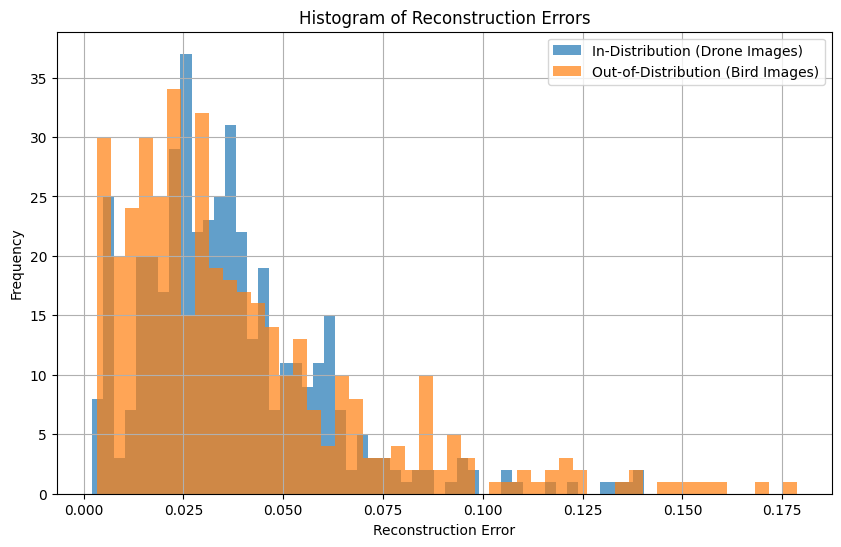

In [24]:
id_errors = calculate_reconstruction_errors(drone_images, vae)
ood_errors = calculate_reconstruction_errors(bird_images, vae)
import matplotlib.pyplot as plt

def plot_histogram(id_errors, ood_errors):
    plt.figure(figsize=(10, 6))
    plt.hist(id_errors, bins=50, alpha=0.7, label='In-Distribution (Drone Images)')
    plt.hist(ood_errors, bins=50, alpha=0.7, label='Out-of-Distribution (Bird Images)')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Histogram of Reconstruction Errors')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histogram(id_errors, ood_errors)
